In [1]:
%matplotlib inline
from sghmc_pkg.algorithms_sim import HMC_sim, SGHMC_NAIVE_sim, SGHMC_sim, SGLD_sim
from sghmc_pkg.algorithms_data import SGHMC_data, SGLD_data, SGDwm_data
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.integrate import quad
import pandas as pd
from sklearn import preprocessing
import datetime as dt
import numba
from numba import jit
import warnings
warnings.filterwarnings('ignore')

### Simulation

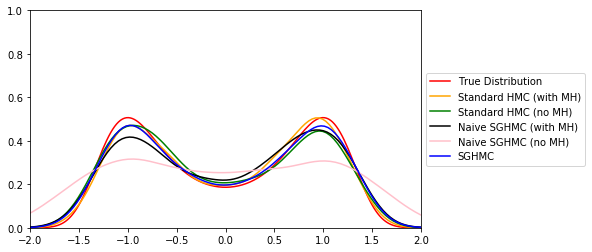

In [2]:
# true distribution
p_func = lambda x: np.exp(2*x**2 - x**4)
xs = np.linspace(-2, 2, 200)
ys = p_func(xs)/quad(p_func, float('-Inf'), float('Inf'))[0]

# standard HMC
u_func = lambda x: -2*x**2 + x**4
du_func = lambda x: -4*x + 4*x**3
epsilon = 0.1
nt = 10000
m = 50
M = 1
theta_init = 0
theta_hmc_mh = HMC_sim(u_func, du_func, epsilon, nt, m, M, theta_init, None, MH = True, resample = True).theta()
theta_hmc_nomh = HMC_sim(u_func, du_func, epsilon, nt, m, M, theta_init, None, MH = False, resample = True).theta()

# Naive stochastic gradient HMC
V = 4
u_hat_func = u_func
formula = lambda x: 0
du_hat_func = lambda x:  -4*x + 4*x**3 + np.random.normal(0, np.sqrt(V))
theta_naive_mh = SGHMC_NAIVE_sim(u_hat_func, du_hat_func, epsilon, nt, m, M, V, theta_init, None, formula, MH = True, resample = True).theta()
theta_naive_nomh = SGHMC_NAIVE_sim(u_hat_func, du_hat_func, epsilon, nt, m, M, V, theta_init, None, formula, MH = False, resample = True).theta()

# SGHMC
B_hat = C = 1/2*epsilon*V
theta_sghmc = SGHMC_sim(du_hat_func, epsilon, nt, m, M, C, B_hat, theta_init, None, formula, resample = True).theta()

# plot
plt.subplots(figsize=(7, 4))
plt.plot(xs, ys, color = 'red', label = 'True Distribution')
sns.distplot(theta_hmc_mh, hist = False, color = 'orange', label = 'Standard HMC (with MH)')
sns.distplot(theta_hmc_nomh, hist = False, color = 'green', label = 'Standard HMC (no MH)')
sns.distplot(theta_naive_mh, hist = False, color = 'black', label = 'Naive SGHMC (with MH)')
sns.distplot(theta_naive_nomh, hist = False, color = 'pink', label = 'Naive SGHMC (no MH)')
sns.distplot(theta_sghmc, hist = False, color = 'blue', label = 'SGHMC')
plt.axis([-2, 2, 0, 1,])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

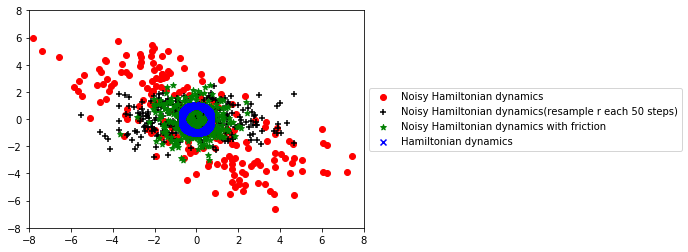

In [3]:
# Noisy Hamiltonian dynamics
u_func = lambda x: 1/2*x**2
du_func = lambda x: x
u_hat_func = lambda x: 1/2*x**2
du_hat_func = lambda x: x + np.random.normal(0, np.sqrt(V))
epsilon = 0.1
nt = 1000
V = 4
M = 1
theta_init = 0
r_init = 1
formula = lambda x: 0
theta_noisy = SGHMC_NAIVE_sim(u_hat_func, du_hat_func, epsilon, nt, 1, M, V, theta_init, r_init, formula, MH = False, resample = False).theta()[::5]
r_noisy = SGHMC_NAIVE_sim(u_hat_func, du_hat_func, epsilon, nt, 1, M, V, theta_init, r_init, formula, MH = False, resample = False).r()[::5]

# Noisy Hamiltonian dynamics (resample r each 50 steps)
nt = 300
m = 50
theta_noisy_resample = SGHMC_NAIVE_sim(u_hat_func, du_hat_func, epsilon, nt, m, M, V, theta_init, None, formula, MH = False, resample = True).theta()
r_noisy_resample = SGHMC_NAIVE_sim(u_hat_func, du_hat_func, epsilon, nt, m, M, V, theta_init, None, formula, MH = False, resample = True).r()

# Noisy Hamiltonian dynamics with friction
B_hat = C = 1/2*epsilon*V
theta_sghmc_2 = SGHMC_sim(du_hat_func, epsilon, nt, m, M, C, B_hat, theta_init, None, formula, resample = True).theta()
r_sghmc_2 = SGHMC_sim(du_hat_func, epsilon, nt, m, M, C, B_hat, theta_init, None, formula, resample = True).r()

# Hamiltonian dynamics
nt = 1000
theta_hmc_2 = HMC_sim(u_func, du_func, epsilon, nt, 1, M, theta_init, r_init, MH = False, resample = False).theta()
r_hmc_2 = HMC_sim(u_func, du_func, epsilon, nt, 1, M, theta_init, r_init, MH = False, resample = False).r()

# plot
plt.scatter(theta_noisy, r_noisy, color = 'red', marker = 'o', label = 'Noisy Hamiltonian dynamics')
plt.scatter(theta_noisy_resample, r_noisy_resample, color = 'black', marker = '+', label = 'Noisy Hamiltonian dynamics(resample r each 50 steps)')
plt.scatter(theta_sghmc_2, r_sghmc_2, color = 'green', marker = '*', label = 'Noisy Hamiltonian dynamics with friction')
plt.scatter(theta_hmc_2, r_hmc_2, color = 'blue', marker = 'x', label = 'Hamiltonian dynamics')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axis([-8, 8, -8, 8,])
plt.show()

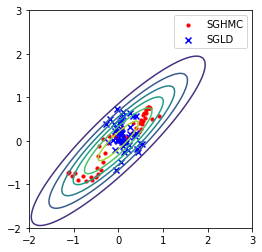

In [4]:
# SGHMC
sigma = np.array([1, 0.9, 0.9, 1]).reshape(2, 2)
u_func = lambda x: 1/2 * x.T @ np.linalg.inv(sigma) @ x
du_hat_func = lambda x: np.linalg.inv(sigma) @ x + np.random.multivariate_normal(np.array([0,0]), np.eye(2))
epsilon = 0.1
nt = 100
M = np.eye(2)
V = np.eye(2)
B_hat = C = 1/2*epsilon*V
theta_init = np.array([0,0])
r_init = np.random.multivariate_normal(np.array([0,0]), M)
formula = lambda x: 0
theta_sghmc = SGHMC_sim(du_hat_func, epsilon, nt, 1, M, C, B_hat, theta_init, r_init, formula, resample = False).theta()

# SGLD
theta_sgld = SGLD_sim(None, du_hat_func, epsilon, nt, 1, M, V, theta_init, r_init, formula, MH = False, resample = False).theta()

# plot
x = np.linspace(-2, 3, 100)
y = np.linspace(-2, 3, 100)
xx, yy = np.meshgrid(x, y)
a, b, c = np.linalg.inv(sigma)[0,0], np.linalg.inv(sigma)[1,1], np.linalg.inv(sigma)[1,0]
z = np.exp(-1/2*(a*xx**2 + b*yy**2 + 2*c*xx*yy))
plt.subplots(figsize=(4,4))
plt.contour(x, y, z, levels = 6)
plt.scatter(np.array(theta_sghmc).T[0][::2], np.array(theta_sghmc).T[1][::2], s = 10, color = 'red', marker = 'o', label = 'SGHMC')
plt.scatter(np.array(theta_sgld).T[0][::2], np.array(theta_sgld).T[1][::2], color = 'blue', marker = 'x', label = 'SGLD')
plt.legend(loc="upper right")
plt.show()

### Real Data

#### Linear Regression

In [5]:
# For linear regression
def du_hat_func(beta, X, y, m):
    # prior: beta ~ N(np.zeros(p), I/phi)
    d1 = X.T @ X @ beta - X.T @ y
    d2 = beta
    return(m*d1 + d2)

# test error
def test_error(X, y, theta):
    y_pred = X @ np.array(theta).T
    z = ((y[:,None] - y_pred)**2).sum(axis = 0)/len(y)
    return(z)

# data
# https://www.kaggle.com/uciml/adult-census-income
data = pd.read_csv('insurance.csv')
data.sex = data.sex.factorize()[0]
data.smoker = data.smoker.factorize()[0]
data.region = data.region.factorize()[0]
data = preprocessing.scale(data)
X = data[:1000, :-1]
X_test = data[1000:, :-1]
y = data[:1000, -1]
y_test = data[1000:, -1]

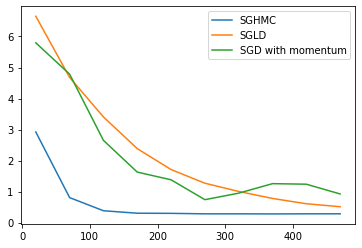

In [6]:
# SGHMC
n, p = X.shape
epsilon = 0.005
nt = 1000
m = 5
M = C = B_hat = np.eye(p)
theta_init = r_init = np.ones(p)
formula = lambda x: 0
theta_sghmc = SGHMC_data(X, y, du_hat_func, epsilon, nt, m, M, C, B_hat, theta_init, r_init, formula, resample = False).theta()

# SGLD
B = np.eye(p)
epsilon = 0.0009
theta_sgld = SGLD_data(X, y, None, du_hat_func, epsilon, nt, m, M, B, theta_init, r_init, formula, MH = False, resample = False).theta()

# SGD with momentum
v_init = epsilon*np.linalg.inv(M)@r_init
theta_sgdwm = SGDwm_data(X, y, None, du_hat_func, epsilon, nt, m, M, C, B_hat, theta_init, v_init, formula, MH = False, resample = False).theta()

# plot
xs = np.arange(20,500,50)
plt.plot(xs, test_error(X_test, y_test, theta_sghmc[20:500][::50]), label = 'SGHMC')
plt.plot(xs, test_error(X_test, y_test, theta_sgld[20:500][::50]), label = 'SGLD')
plt.plot(xs, test_error(X_test, y_test, theta_sgdwm[20:500][::50]), label = 'SGD with momentum')
plt.legend(loc = 'upper right')
pass

#### logistic regression

In [7]:
# For logistic regression
def du_hat_func(beta, X, y, m):
    z = y - 1/(1 + np.exp(-np.dot(X, beta)))
    d1 = X.T @ z
    d2 = - np.dot(np.linalg.inv(sigma), beta)
    return(- m*d1 - d2)

# test error
def test_error(X, y, theta):
    y_pred = (1/(1 + np.exp(- X @ np.array(theta).T)) > 0.5).astype(int)
    z = ((y[:,None] - y_pred)**2).sum(axis = 0)/len(y)
    return z

# training data
data_train = pd.read_csv('logis.csv')
data_train.drop('Unnamed: 0', axis = 1, inplace = True)
data_train.date = pd.to_datetime(data_train.date)
data_train.date = data_train.date.map(dt.datetime.toordinal)
X = np.array(data_train.loc[:5699, :'HumidityRatio'])
X = preprocessing.scale(X)/10
y = np.array(data_train.loc[:5699, 'Occupancy'])

# testing data
data_test = pd.read_csv('logis_test.csv')
data_test.drop('Unnamed: 0',axis = 1, inplace = True)
data_test.date = pd.to_datetime(data_test.date)
data_test.date = data_test.date.map(dt.datetime.toordinal)
X_test = np.array(data_test.loc[:,:'HumidityRatio'])
X_test = preprocessing.scale(X_test)/10
y_test = np.array(data_test.loc[:, 'Occupancy'])

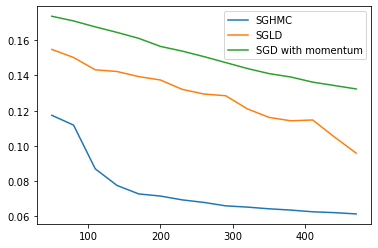

In [8]:
# SGHMC
n, p = X.shape
sigma = np.eye(p)
epsilon = 0.001
nt = 1000
m = 10
M = C = B_hat = np.eye(p)
theta_init = r_init = np.ones(p)
formula = lambda x: 0
theta_sghmc = SGHMC_data(X, y, du_hat_func, epsilon, nt, m, M, C, B_hat, theta_init, r_init, formula, resample = True).theta()

# SGLD
B = np.eye(p)
epsilon = 0.001
theta_sgld = SGLD_data(X, y, None, du_hat_func, epsilon, nt, m, M, B, theta_init, r_init, formula, MH = False, resample = False).theta()

# SGD with momentum
epsilon = 0.001
m = 5
v_init = r_init
theta_sgdwm = SGDwm_data(X, y, None, du_hat_func, epsilon, nt, m, M, C, B_hat, theta_init, v_init, formula, MH = False, resample = False).theta()

# plot
xs = np.arange(50,500,30)
plt.plot(xs, test_error(X_test, y_test, theta_sghmc[50:500][::30]), label = 'SGHMC')
plt.plot(xs, test_error(X_test, y_test, theta_sgld[50:500][::30]), label = 'SGLD')
plt.plot(xs, test_error(X_test, y_test, theta_sgdwm[50:500][::30]), label = 'SGD with momentum')
plt.legend(loc = 'upper right')
pass